# **Thanks for the code [StyleGAN2_Encoder](https://github.com/roluxstylegan2encoder), [StyleGAN2-Face-Modificator](https://github.com/tg-bomze/StyleGAN2-Face-Modificator) and a set of latent vectors [Generators-with-Stylegan2](https://github.com/a312863063/generators-with-stylegan2/blob/master/README_EN.md). The code is implemented in Pytorch 1.7.** 

**Nan Yang (Ph.D Candidate)**

**Shenyang Institute of Automation, Chinese Academy of Sciences** 

**E-mail： yangnansia@gmail.com **

**Address: No. 19 Nanta Road, Shenhe District, Shenyang, Liaoning 110179**








In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/DNI-Code")
!pip install ninja

     |████████████████████████████████| 112kB 5.4MB/s 


In [3]:
#%%
#@title #**Declare the necessary functions** { display-mode: "form" }
import torch
import math
import pickle
import imageio
import io
import PIL.Image
import numpy as np
from PIL import Image
import moviepy.editor as mpy
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
%matplotlib inline

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")

def make_image(tensor):
    return (
        tensor.detach()
            .clamp_(min=-1, max=1)
            .add(1)
            .div_(2)
            .mul(255)
            .type(torch.uint8)
            .permute(0, 2, 3, 1)
            .to("cpu")
            .numpy()
    )

def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network):
    direction = np.load('latent_directions/' + direction_file)
    # print(direction.shape) (18, 512)
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        new_latent_vector = torch.tensor(new_latent_vector).to('cuda')
        images, _ = g_ema([new_latent_vector],
                   input_is_latent=True,
                   randomize_noise=False,
                   return_latents=False)
        images = make_image(images)
        result = PIL.Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, PIL.Image.ANTIALIAS)
        result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2113536/45929032 bytes (4.6%)5152768/45929032 bytes (11.2%)7847936/45929032 bytes (17.1%)11124736/45929032 bytes (24.2%)14147584/45929032 bytes (30.8%)17072128/45929032 bytes (37.2%)20512768/45929032 bytes (44.7%)23871488/45929032 bytes (52.0%)27271168/45929032 bytes (59.4%)30556160/45929032 bytes (66.5%)33824768/45929032 bytes (73.6%)37257216/45929032 bytes (81.1%)

In [ ]:
#@title #**Upload a photo with a face** { display-mode: "form" }
from google.colab import files

# !rm -rf raw_images/
# !mkdir raw_images/
#@markdown *Enter a link to the image or leave the **url** field blank (in this case it will be offered to upload a photo from the computer).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = files.upload()
  for fp in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(uploaded[fp])))
else:
  try:
    !wget $url
    fp = url.split('/')[-1]
  except BaseException:
    print("Something went wrong. Try uploading photos from your computer")

os.rename(fp, fp.replace(" ", ""))
#@markdown *Please add the photo name for your images*
name = "baby." #@param ["baby.", "chaomo.", "mingxing."] {allow-input: true}
fp = fp.replace(" ", "")
fn = name + fp.split('.')[-1]
!mv $fp raw_images/$fn
clear_output()
print("Photo uploaded:\n")

img1 = PIL.Image.open('raw_images/'+fn)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), PIL.Image.LANCZOS)
display(img1)

In [ ]:
#%%
#@title #**Crop photo** { display-mode: "form" }
!python align_images.py ./raw_images/ ./align_images/
clear_output()

In [ ]:
#@title #**Train a neural network (~5-10 min.)** { display-mode: "form" }
%%time
#@markdown **Choose an image encoding method:**

#@markdown *Slow method works 2 times longer, but has much higher quality.*
metod = "DNI" #@param ["DNI"]
#@markdown **Set the number of iterations of network learning:**

#@markdown *Recommended: 1000*
iterat = 700 #@param {type:"slider", min:100, max:1500, step:50}

#@markdown **Delete logs after executing this block:**
delete_logs = True #@param {type:"boolean"}

if metod == 'DNI':
  !python encode_image.py \
  --src_dir ./align_images/ \
  --result_file ./result_file/ \
  --dlatent_dir ./dlatent_dir/ \
  --size 1024 \
  --ckpt ./networks/stylegan2-ffhq-config-f.pt \
  --id_ckpt ./networks/dni_identity.pt \
  --se_ckpt ./networks/dni_sematic.pt \
  --mode DNI \
  --step $iterat

pass
if delete_logs == True:
  clear_output()
display_sbs('result_file/', 'align_images/', res = 512)

In [5]:
#%%

#@title #**Configure the generator** { display-mode: "form" }

#@markdown *Below select the network in which the feature vector was generated*

model = '/stylegan2-ffhq-config-f.pt'
networks_urls = {
    'european':['https://drive.google.com/uc?id=1--kh2Em5U1qh-H7Lin9FzppkZCQ18c4W','generator_model-stylegan2-config-f.pkl'],
    'asian':['https://drive.google.com/uc?id=1-3XU6KzIVywFoKXx2zG1hW8mH4OYpyO9','generator_yellow-stylegan2-config-f.pkl'],
    'asian beauty':['https://drive.google.com/uc?id=1-04v78_pI59M0IvhcKxsm3YhK2-plnbj','generator_star-stylegan2-config-f.pkl'],
    'baby':['https://drive.google.com/uc?id=1--684mANXSgC3aDhLc7lPM7OBHWuVRXa','generator_baby-stylegan2-config-f.pkl']}

network = 'default' #@param ["default", "european", "asian", "asian beauty", "baby"]

if network == 'default':
  network_pkl = 'networks/' + model
else:
  other_networks = !ls networks/other
  if networks_urls[network][1] in other_networks:
    network_pkl = 'networks/other/' + networks_urls[network][1]
  else:
    network_url = networks_urls[network][0]
    try:
      !gdown $network_url
      network_name = networks_urls[network][1]
      !mv $network_name networks/other/$network_name
      network_pkl = 'networks/other/' + network_name
    except BaseException:
      network_pkl = 'networks/other/' + networks_urls[network][1]

from model import Generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load(network_pkl)["g_ema"], strict=True)
g_ema.eval()
g_ema = g_ema.to(device)
print('StyleGAN2 Model Load Sccess')

StyleGAN2 Model Load Sccess


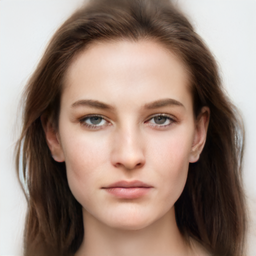

In [17]:
#%%
#@title #**Modify the face in photo** { run: "auto", display-mode: "form" }
from google.colab import files

#@markdown **Choose what inverse code you would like to change:**
inverse_code = 'chaomo.npy' #@param ["chaomo.npy", "mingxing.npy"]

v = np.load('dlatent_dir/'+ inverse_code)
v = np.array([v]) # (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'emotion_surprise' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Parameter intensity:**
intensity = -0.9 #@param {type:"slider", min:-20, max:20, step:0.1}
#@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
boost_intensity = True #@param {type:"boolean"}
if boost_intensity == True:
  intensity *= 5
coeffs = [intensity]
#@markdown **Image resolution:**
resolution = "256" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)
move_latent_and_save(v, direction_file, coeffs, g_ema)

In [ ]:
#@title #**Animating a face modification** { display-mode: "form" }
from google.colab import files
#@markdown **Choose what inverse code you would like to change:**
inverse_code = 'mingxing.npy' #@param ["chaomo.npy", "mingxing.npy"]

v = np.load('dlatent_dir/'+ inverse_code)
v = np.array([v]) # (* truncation_psi)
!rm -rf results/$direction_name

#@markdown **Choose what you would like to change.:**
parameter = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eye_distance", "eye_eyebrow_distance", "eye_ratio", "eyes_open", "face_shape", "gender", "glasses", "height", "lip_ratio", "mouth_open", "mouth_ratio", "nose_mouth_distance", "nose_ratio", "nose_tip", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file = parameter + '.npy'
direction_name = direction_file.split('.')[0]
#@markdown **Starting intensity:**
start_intensity = -3.4 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Finishing intensity:**
finish_intensity = 2 #@param {type:"slider", min:-20, max:20, step:0.2}
#@markdown **Number of frames:**
frames = 50 #@param {type:"slider", min:10, max:100, step:1}

if finish_intensity > start_intensity:
  #@markdown *If you set the boost_intensity, then the intensity will increase 3 times.*
  boost_intensity = True #@param {type:"boolean"}
  if boost_intensity == True:
    start_intensity *= 3
    finish_intensity *= 3
  
  duration = abs(start_intensity)+abs(finish_intensity)
  steps = round(duration/frames,2)
  coeffs = []

  for i in range(int(start_intensity*100), int(finish_intensity*100), int(steps*100)):
    coeffs.append(i/100)
  #@markdown **Animation Resolution:**
  resolution = "256" #@param [128, 256, 512, 1024]
  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction_file, coeffs, g_ema)

  #@markdown **Add video Invert:**

  add_invert = True #@param {type:"boolean"}
  face_img = []
  img = os.listdir("results/"+direction_name)
  # img = list(filter(os.path.isfile, img))
  img.sort()
  for i in img:
    face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  if add_invert == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)
  imageio.mimsave("results/" + direction_name + "/" + direction_name + ".mp4", face_img)
  display(mpy.ipython_display("results/" + direction_name + "/" + direction_name + ".mp4", height=400, autoplay=1, loop=1))
else:
  print('Starting intensity should be less than the finish!')